In [7]:
from pathlib import Path 

import torch
import timm
from ml.vision.data import ImageDataModule
from timm.data import transforms_factory

In [8]:
m = timm.create_model('resnet50', pretrained=True, num_classes=0, global_pool='')
m.to("cuda");

In [9]:
test_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=False,
)

In [10]:
test_image_paths = list(Path("../data/train/").glob("*.jpg"))
test_image_paths[:5]

[PosixPath('../data/train/c05fc6c26ed3a25760acd313a2557a30.jpg'),
 PosixPath('../data/train/ee042113639bc026c49305137511a866.jpg'),
 PosixPath('../data/train/821b77dee521fcf9d5bfdf97e5d8a0b0.jpg'),
 PosixPath('../data/train/8c6578b304039b0c2da4e79df723e3bd.jpg'),
 PosixPath('../data/train/1266dfa9bad7ab3c2cbee98fa1ac51f6.jpg')]

In [11]:
dm = ImageDataModule(
    task="classification",
    batch_size=32,
    # test
    test_image_paths=test_image_paths,
    test_augmentations=test_aug,
)
dm.setup()

In [12]:
fx = []
for batch in dm.test_dataloader():
    batch = batch.to("cuda")
    fx.extend(m(batch).detach().cpu().numpy())

In [13]:
actns = torch.tensor(fx)
actns = actns.to('cuda')
actns = actns.reshape(len(test_image_paths), -1)

/tmp/ipykernel_3687005/1019073057.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  actns = torch.tensor(fx)


In [14]:
actns.shape

torch.Size([9912, 100352])

In [79]:
def cosine_distance_torch(a, b=None, eps=1e-8):
#     x2 = x1 if x2 is None else x2
#     w1 = x1.norm(p=2, dim=1, keepdim=True)
#     w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.clamp(a_n, min=eps)
    b_norm = b / torch.clamp(b_n, min=eps)
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
    
#     return 1 - torch.mm(x1, x2.t()) / (w1 * w2.t())#.clamp(min=eps)

In [80]:
sims = cosine_distance_torch(actns, actns)
sims = torch.triu(sims, diagonal=1)

In [81]:
sims[:10, :10]

tensor([[0.0000, 0.0649, 0.0631, 0.0895, 0.0657, 0.0649, 0.0587, 0.0551, 0.0681,
         0.0493],
        [0.0000, 0.0000, 0.1195, 0.0612, 0.0849, 0.0592, 0.0478, 0.0685, 0.0903,
         0.0653],
        [0.0000, 0.0000, 0.0000, 0.0546, 0.0938, 0.0561, 0.0944, 0.1258, 0.1256,
         0.1061],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0941, 0.0641, 0.0632, 0.0471, 0.0503,
         0.0634],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0939, 0.0711, 0.0597, 0.0636,
         0.0915],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0563, 0.0409, 0.0522,
         0.1031],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0569, 0.0896,
         0.1017],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0860,
         0.0494],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1525],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='c

In [82]:
sims.min(), sims.max()

(tensor(0., device='cuda:0'), tensor(0.8152, device='cuda:0'))

In [83]:
(sims > 0.60).sum()

tensor(21, device='cuda:0')

In [91]:
x, y = torch.where(sims > 0.60)
prob = sims[x, y]

In [93]:
x, y, prob

(tensor([ 344,  408,  614,  735, 1256, 1666, 2172, 2464, 2638, 2944, 3522, 3547,
         3556, 3573, 3707, 3721, 4513, 5114, 5380, 8035, 8060], device='cuda:0'),
 tensor([5281, 5237, 5331, 2647, 2007, 9308, 3152, 6942, 9522, 6276, 5948, 5933,
         5575, 4456, 5011, 4210, 5689, 8634, 8227, 8143, 8516], device='cuda:0'),
 tensor([0.6204, 0.6294, 0.8152, 0.7414, 0.7291, 0.7255, 0.6735, 0.6677, 0.6662,
         0.7473, 0.6478, 0.7478, 0.6547, 0.6362, 0.6425, 0.6524, 0.7196, 0.6977,
         0.6694, 0.6239, 0.6630], device='cuda:0'))

In [90]:
dups

tensor([[ 344, 5281],
        [ 408, 5237],
        [ 614, 5331],
        [ 735, 2647],
        [1256, 2007],
        [1666, 9308],
        [2172, 3152],
        [2464, 6942],
        [2638, 9522],
        [2944, 6276],
        [3522, 5948],
        [3547, 5933],
        [3556, 5575],
        [3573, 4456],
        [3707, 5011],
        [3721, 4210],
        [4513, 5689],
        [5114, 8634],
        [5380, 8227],
        [8035, 8143],
        [8060, 8516]], device='cuda:0')

In [72]:
idx = torch.argsort(dups[:, 2], descending=True)
sorted_dups = dups[idx, :]

In [73]:
sorted_dups

tensor([[6.1400e+02, 5.3310e+03, 8.1517e-01],
        [3.5470e+03, 5.9330e+03, 7.4775e-01],
        [2.9440e+03, 6.2760e+03, 7.4730e-01],
        [7.3500e+02, 2.6470e+03, 7.4142e-01],
        [1.2560e+03, 2.0070e+03, 7.2911e-01],
        [1.6660e+03, 9.3080e+03, 7.2546e-01],
        [4.5130e+03, 5.6890e+03, 7.1957e-01],
        [5.1140e+03, 8.6340e+03, 6.9774e-01],
        [2.1720e+03, 3.1520e+03, 6.7348e-01],
        [5.3800e+03, 8.2270e+03, 6.6939e-01],
        [2.4640e+03, 6.9420e+03, 6.6775e-01],
        [2.6380e+03, 9.5220e+03, 6.6619e-01],
        [8.0600e+03, 8.5160e+03, 6.6303e-01],
        [3.5560e+03, 5.5750e+03, 6.5469e-01],
        [3.7210e+03, 4.2100e+03, 6.5244e-01],
        [3.5220e+03, 5.9480e+03, 6.4778e-01],
        [3.7070e+03, 5.0110e+03, 6.4254e-01],
        [3.5730e+03, 4.4560e+03, 6.3618e-01],
        [4.0800e+02, 5.2370e+03, 6.2936e-01],
        [8.0350e+03, 8.1430e+03, 6.2394e-01],
        [3.4400e+02, 5.2810e+03, 6.2037e-01]], device='cuda:0')

In [77]:
from PIL import Image 


for idx, a in enumerate(sorted_dups):
    print(a)
#     Image.open(test_image_paths[a[0]])

tensor([6.1400e+02, 5.3310e+03, 8.1517e-01], device='cuda:0')
tensor([3.5470e+03, 5.9330e+03, 7.4775e-01], device='cuda:0')
tensor([2.9440e+03, 6.2760e+03, 7.4730e-01], device='cuda:0')
tensor([7.3500e+02, 2.6470e+03, 7.4142e-01], device='cuda:0')
tensor([1.2560e+03, 2.0070e+03, 7.2911e-01], device='cuda:0')
tensor([1.6660e+03, 9.3080e+03, 7.2546e-01], device='cuda:0')
tensor([4.5130e+03, 5.6890e+03, 7.1957e-01], device='cuda:0')
tensor([5.1140e+03, 8.6340e+03, 6.9774e-01], device='cuda:0')
tensor([2.1720e+03, 3.1520e+03, 6.7348e-01], device='cuda:0')
tensor([5.3800e+03, 8.2270e+03, 6.6939e-01], device='cuda:0')
tensor([2.4640e+03, 6.9420e+03, 6.6775e-01], device='cuda:0')
tensor([2.6380e+03, 9.5220e+03, 6.6619e-01], device='cuda:0')
tensor([8.0600e+03, 8.5160e+03, 6.6303e-01], device='cuda:0')
tensor([3.5560e+03, 5.5750e+03, 6.5469e-01], device='cuda:0')
tensor([3.7210e+03, 4.2100e+03, 6.5244e-01], device='cuda:0')
tensor([3.5220e+03, 5.9480e+03, 6.4778e-01], device='cuda:0')
tensor([

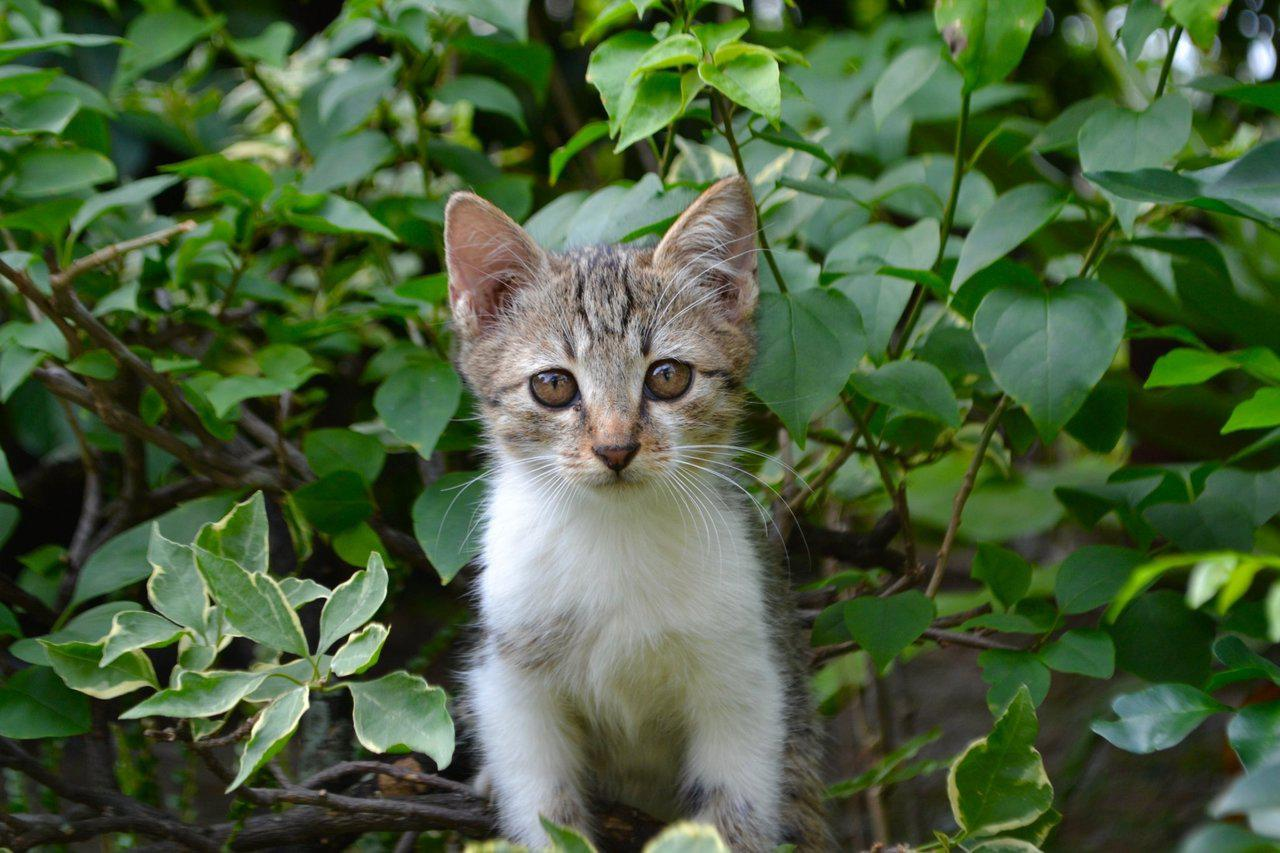

In [51]:
Image.open(test_image_paths[y[2]])

## Find duplicate images in Petfinder Adoption dataset

In [2]:
import itertools
import collections
from pathlib import Path

from PIL import Image
import cv2
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import imagehash

import matplotlib.pyplot as plt

In [3]:
def run():

    funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
        #lambda x: imagehash.whash(x, mode='db4'),
    ]

    petids = []
    hashes = []
    for path in tqdm(Path("../data/extra/").glob("*.jpg")):

        image = Image.open(path)
        imageid = path.stem

        petids.append(imageid)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

    return petids, np.array(hashes)

%time petids, hashes_all = run()


0it [00:00, ?it/s]

CPU times: user 9min 44s, sys: 5.79 s, total: 9min 50s
Wall time: 10min 1s


In [4]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

In [ ]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [ ]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
petids1 = [petids[i] for i in indices1[0][indices2]]
petids2 = [petids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([petid1,petid2])):True for petid1, petid2 in zip(petids1, petids2)}
print('found %d duplicates' % len(dups))

In [ ]:
sims

In [ ]:
train = pd.read_csv('../input/train/train.csv')
test = pd.read_csv('../input/test/test.csv')

train.loc[:,'Category'] = 'train'
test.loc[:,'Category'] = 'test'
test.loc[:,'AdoptionSpeed'] = np.nan

df = pd.concat([train, test], sort=False)

In [ ]:
detail = {petid:df[df.PetID == petid].iloc[0] for petid in itertools.chain.from_iterable(list(dups))}

In [ ]:
def show(row1, row2):

    print('PetID: %s / %s' % (row1.PetID, row2.PetID))
    print('Name: %s / %s' % (row1.Name, row2.Name))
    print('Category: %s / %s' % (row1.Category, row2.Category))
    print('AdoptionSpeed: %s / %s' % (row1.AdoptionSpeed, row2.AdoptionSpeed))
    print('Breed1: %d / %d' % (row1.Breed1, row2.Breed1))
    print('Age: %d / %d' % (row1.Age, row2.Age))
    print('RescuerID:\n%s\n%s' % (row1.RescuerID, row2.RescuerID))
    
    image1 = cv2.imread('../input/%s_images/%s-1.jpg' % (row1.Category, row1.PetID))
    image2 = cv2.imread('../input/%s_images/%s-1.jpg' % (row2.Category, row2.PetID))
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()

In [ ]:
for petid1, petid2 in sorted(list(dups)):
    row1 = detail[petid1]
    row2 = detail[petid2]
    if row1.Category != row2.Category:
        show(row1, row2)

## Find Petfinder Pawpularity images already included in Petfinder Adoption dataset

In [ ]:
# compute hash for competition dataset

